#### Business Analytics FHDW 2025
# Einfaktorielle Varianzanalyse
## am Beispiel von Schokolade

Als Fallbeispiel schauen wir uns ein Szenario aus *Backhaus et al.: Multivariate Analysemethoden* an. Eine Supermarktkette möchte die Auswirkung unterschiedlicher Platzierungen eines Schokoladenprodukts auf dessen Absatz analysieren. *Platzierung* ist also der Faktor, seine Ausprägungen sind die Faktorstufen *1. Süßwarenabteilung*, *2. Sonderplatzierung* und *3. Kassenplatzierung*.

Das experimentelle Design wählt aus 100 Filialen 15 zufällig aus. In jeweils fünf wieder zufällig ausgewählten Filialen wird für eine Woche eine der Produktplatzierungen umgesetzt. Nach dieser Woche berichtet jeder Markt den Absatz in "Kilogramm pro 1000 Kassenvorgänge". 

Diese Zahlen lesen wir aus der Beispieldatei ein.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as sta

schoko_df = pd.read_csv('Daten/anova_bsp_schoko.csv')
schoko_df

,Süßwarenabteilung,Sonderplatzierung,Kassenplatzierung
0,47,68,59
1,39,65,50
2,40,63,51
3,46,59,48
4,45,67,53


### Modellformulierung und erste Betrachtungen

Wir betrachten in diesem Beispiel nur einen Faktor. Die *einfaktorielle* Varianzanalyse bildet dann das Modell 

$y_{gi}=\mu+\alpha_{g}+\epsilon_{gi}$ 

mit <br>
$y_{gi}$ Beobachtungswert $i=1,...,5$ für Faktorstufe $g=1,...,3$<br>
$\mu$ Gesamtmittelwert in der Grundgesamtheit<br>
$\alpha_{g} = \mu_{g}-\mu$ wahrer Effekt von Faktorstufe $g$ mit $\mu_{g}$ dem Mittelwert der Faktorstufe $g$ in der Grundgesamtheit. Die Werte können wir mit den Gruppenmittelwerten der Stichprobe schätzen als $a_{g}=\overline{y}_{g}-\overline{y}$. <br>
$\epsilon_{gi}$ Störgröße<br>

Oft hilfreich - wenn die Dimensionalität das zulässt - ist eine Visualisierung der Daten. Zum Vergleich von Stichproben bietet sich ein *Boxplot* an, der eine Reihe von statistischen Eigenschaften darstellt.

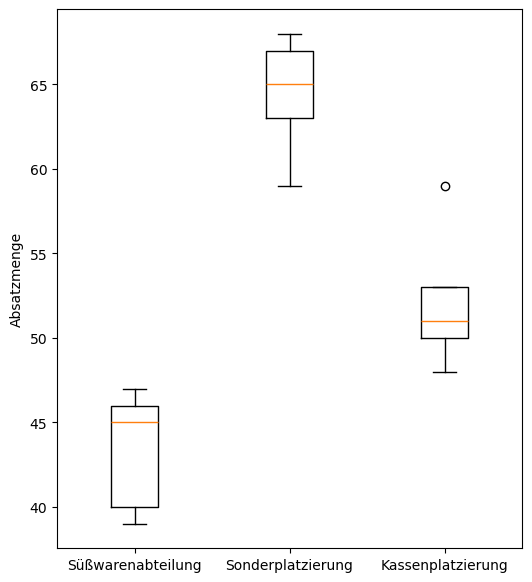

In [2]:
fig, ax = plt.subplots(figsize=(6, 7))
ax.boxplot(schoko_df[[p for p in schoko_df.columns]])
plt.xticks(ticks=[1,2,3], labels=schoko_df.columns)
ax.set_ylabel('Absatzmenge')
plt.show()

Der Boxplot zeigt uns, dass sich die Absatzmengen zwischen den Platzierungen unterscheiden. Da die Mengen aber auch innerhalb der drei Gruppen Streuungen zeigen, muss es noch andere Einflüsse in Form von Stör- bzw. Zufallsgrößen geben. Den Effekt einer Platzierung betrachten wir also als *Hypothese*, die wir mit der ANOVA prüfen wollen. 

Dazu ermitteln wir schon einmal die Mittelwerte der Faktorstufen und die Schätzungen der wahren Effekte auf Grundlage der Stichprobe.

In [3]:
gesamtmittel = schoko_df.mean().sum()/len(schoko_df.mean())

mittelwerte_df = pd.DataFrame(columns=['Gruppenmittelwert','Wahrer Effekt'], 
                              index=['Süßwarenabteilung','Sonderplatzierung','Kassenplatzierung'])
mittelwerte_df['Gruppenmittelwert'] = [schoko_df[p].mean() for p in schoko_df.columns]
mittelwerte_df['Wahrer Effekt'] = [gruppenmittel-gesamtmittel for gruppenmittel in mittelwerte_df.Gruppenmittelwert]
mittelwerte_df

,Gruppenmittelwert,Wahrer Effekt
Süßwarenabteilung,43.4,-9.933333
Sonderplatzierung,64.4,11.066667
Kassenplatzierung,52.2,-1.133333


Hier sehen wir in Zahlen, wie die *Sonderplatzierung* den stärksten positiven Effekt bringt und die *Süßwarenabteilung* zum durchschnittlich geringsten Absatz führt. Was wir noch nicht wissen, ist, ob diese Effekte wirklich durch die Platzierung oder einfach zufällig durch Störgrößen entstanden sind. Dazu müssen wir eine *Streuungs-* bzw. *Varianzzerlegung* vornehmen. 

### Zerlegung der Streuung und Modellgüte

Um die Beobachtungswerte der abhängigen Variable erklären zu können, zerlegt die ANOVA deren Varianz in einen durch das Modell *erklärten* und einen *nicht erklärten* Anteil, also 

*Gesamtstreuung* $SS_{t(otal)}=$ *erklärte Streuung* $SS_{b(etween)}$ + *nicht erklärte Streuung* $SS_{w(ithin)}$ 

($SS$ als *sum of squares*), genauer für den einfaktoriellen Fall:

$\sum\limits_{g=1}^{G}{\sum\limits_{i=1}^{N}(y_{gi}-\overline{y})^2} 
= \sum\limits_{g=1}^{G}{N(\overline{y}_g-\overline{y})^2} + \sum\limits_{g=1}^{G}{\sum\limits_{i=1}^{N}(y_{gi}-\overline{y}_g)^2}$

Mit dem oben formulierten Modell können wir die Streuungen *zwischen* den Gruppen erklären. Stellen wir die einzelnen Summen für die Beispieldaten auf.

In [4]:
abweichungsquadrate_df = pd.DataFrame(columns=['SSt','SSb','SSw'],
                                      index=['Süßwarenabteilung','Sonderplatzierung','Kassenplatzierung'])

abweichungsquadrate_df['SSt'] = [np.sum((schoko_df[kategorie]-gesamtmittel)**2) for kategorie in abweichungsquadrate_df.index]
abweichungsquadrate_df['SSb'] = [np.sum(len(schoko_df[kategorie])
                                        *(mittelwerte_df['Gruppenmittelwert'][kategorie]-gesamtmittel)**2) 
                                 for kategorie in abweichungsquadrate_df.index]
abweichungsquadrate_df['SSw'] = [np.sum((schoko_df[kategorie]-mittelwerte_df['Gruppenmittelwert'][kategorie])**2) 
                                 for kategorie in abweichungsquadrate_df.index]
SSt = np.sum(abweichungsquadrate_df['SSt'])
SSb = np.sum(abweichungsquadrate_df['SSb'])
SSw = np.sum(abweichungsquadrate_df['SSw'])

abweichungsquadrate_df.loc['Summe'] = [SSt, SSb, SSw]
abweichungsquadrate_df

,SSt,SSb,SSw
Süßwarenabteilung,546.555556,493.355556,53.2
Sonderplatzierung,663.555556,612.355556,51.2
Kassenplatzierung,77.222222,6.422222,70.8
Summe,1287.333333,1112.133333,175.2


Durch die Form der Platzierung können wir hier also eine Streuung vom Umfang 1112.13 erklären, 175.2 bleiben unerklärt. Das könnten wir auch auf die einzelnen Märkte herunterbrechen.

Ein Maß für die Erklärungskraft und Güte unseres varianzanalytischen Modells liefert *Eta-Quadrat* als Beziehung zwischen seiner erklärten Streuung zur Gesamtstreuung, $EtaQuadrat = \frac{SS_b}{SS_t}$. Mit Werten zwischen 0 und 1 zeigen hohe Werte, dass das geschätzte Modell die Daten der Stichprobe gut erklärt. Eta-Quadrat entspricht dem Bestimmtheitsmaß $R^2$ der Regressionsanalyse, das ebenfalls den Anteil der Streuung angibt, der dort durch das Regressionsmodell erklärt wird. 

Für unser Beispiel ergibt sich:

In [5]:
eta_quadrat = SSb/SSt
print("Eta-Quadrat = {:.2f}%, {:.2f}% bleiben unerklärt.".format(eta_quadrat*100, (1-eta_quadrat)*100))

Eta-Quadrat = 86.39%, 13.61% bleiben unerklärt.


### Prüfung der statistischen Signifikanzen

Der hohe Eta-Quadrat-Wert zeigt, dass unser Modell die Daten der *Stichprobe* recht gut erklärt. Um auf die *Grundgesamtheit* zu schließen, nutzt die ANOVA die *F-Statistik*. Mit deren *F-Test* können wir nun die Hypothese prüfen, ob der betrachtete Faktor *Platzierung* einen Effekt $\alpha_g$ hat, der dazu beiträgt, die Streuung der abhängigen Variable $y$ zu erklären. 

Für unser stochastisches ANOVA-Modell führt das zu der Nullhypothese, dass sich die Streuung des untersuchten Faktors zwischen den Gruppen *nicht* von der Streuung innerhalb der Gruppen unterscheidet, die Faktorstufen also einen Einfluss von 0 auf die abhängige Variable haben. Formal:

$H_0: SS_b/SS_w = 1$<br>
$H_1: SS_b/SS_w > 1$

Für den praktischen Test berechnen wir eine empirische Prüfgröße $F_{emp}$, die die erklärte Varianz zwischen den Gruppen mit der unerklärten Varianz innerhalb der Gruppen in Beziehung setzt. Sie bildet dazu einen Quotienten aus den mittleren quadratischen Abweichungen $MS$ (*mean squares*), welche die Streuungen $SS$ durch die jeweiligen Freiheitsgrade $df$ (*degrees of freedom*) dividieren:

$F_{emp}=\frac{SS_b/(G-1)}{SS_w/G(N-1)}=\frac{MS_b}{MS_w}$

Aus diesen Informationen setzt sich die *ANOVA-Tabelle* zusammen.

In [6]:
G = len(schoko_df.columns)
N = len(schoko_df.index)
df_ssb = G-1
df_ssw = G*(N-1)
MSb = SSb/df_ssb
MSw = SSw/df_ssw
F_emp = MSb/MSw

anova_df = pd.DataFrame({'SS':[SSb,SSw,SSt],
                         'df':[df_ssb,df_ssw,G*N-1],
                         'MS':[MSb,MSw,SSt/(G*N-1)]},
                        index=['Zwischen Faktorstufen','Innerhalb Faktorstufen','Gesamt'])
anova_df.index.name = 'Varianzquelle'
anova_df

,SS,df,MS
Varianzquelle,,,
Zwischen Faktorstufen,1112.133333,2,556.066667
Innerhalb Faktorstufen,175.200000,12,14.600000
Gesamt,1287.333333,14,91.952381


Bei geringen Störeinflüssen ist dieser Wert hoch und kleine Effekte durch den Faktor signifikant. Bei steigenden Störungen wird der Nachweis eines signifikanten Faktors entsprechend schwieriger - das "Signal" hat Schwierigkeiten, das "Rauschen" zu übertönen.

Den empirischen F-Wert vergleichen wir nun mit dem theoretischen F-Wert $F_\alpha$ der Verteilung. In deren Funktion setzen wir die Freiheitsgrade von oben und wählen eine Irrtumswahrscheinlichkeit $\alpha$ als Signifikanzniveau des Tests. Die Entscheidung über Ablehnung oder Annahme der Nullhypothese lautet dann:

$F_{emp} > F_\alpha \rightarrow H_0$ wird verworfen $\rightarrow$ Zusammenhang zwischen Faktorstufen und der abhängigen Variablen ist signifikant<br>
$F_{emp} \le F_\alpha \rightarrow H_0$ wird nicht verworfen

Mit der Irrtumswahrscheinlichkeit $\alpha$ lehnen wir die Nullhypothese ab, obwohl sie richtig ist (Fehler 1. Art). $\alpha = 5\%$ ist eine Art "Goldstandard" (nach R. A. Fisher). Der konkrete Wert ist aber immer abhängig von den Kosten und Risiken der unterschiedlichen Fehlentscheidungen und damit abhängig vom Anwendungsfall.

Mit $\alpha=0.05$ erhalten wir in unserem Beispiel folgenden Wert für $F_\alpha$:

In [7]:
F_alpha = sta.f.ppf(0.95, dfn=df_ssb, dfd=df_ssw)
print('F_emp = {:.2f}\nF_alpha = {:.2f}'.format(F_emp, F_alpha))

F_emp = 38.09
F_alpha = 3.89


Damit gilt $F_{emp} > F_\alpha$ und wir verwerfen hier die Nullhypothese: Wir können also davon ausgehen, dass die Platzierung der Schokolade einen signifikanten Einfluss auf ihren Absatz hat.

Eine weitere Möglichkeit, die uns eine genauere Wahrscheinlichkeit dafür angibt, dass die Ablehnung der Nullhypothese eine Fehlentscheidung darstellt, liegt im $p$-*Wert* (*probability*). Er wird auf Basis $F_{emp}$ aus der kumulierten Verteilungsfunktion (*cumulative distribution function; cdf*) abgeleitet und führt zur Ablehnung der Nullhypothese, wenn $p<\alpha$. 

In [8]:
p_value = (1 - sta.f.cdf(F_emp, dfn=df_ssb, dfd=df_ssw))
p_value

6.354165506095022e-06

Ein $p$-Wert von praktisch null zeigt hier, wie deutlich sich die Platzierung auf den Absatz auswirkt.

Wenn eine differenzierte Betrachtung eines Szenarios und seiner Daten nicht erforderlich ist, können wir uns $F$- und $p$-Werte auch direkt mit der Funktion `f_oneway` aus dem Datensatz generieren lassen:

In [9]:
F_emp_oneway, p_value_oneway = sta.f_oneway(schoko_df['Süßwarenabteilung'], 
                                            schoko_df['Sonderplatzierung'], 
                                            schoko_df['Kassenplatzierung'])
print(F_emp_oneway, p_value_oneway)

38.08675799086757 6.354165506118907e-06


## Aufgabe

Betrachten Sie die Datei *groessen.csv*, die Stichproben der Körpergrößen von Sportlern verschiedener Disziplinen enthält. Führen Sie eine Varianzanalyse des Einflussfaktors *Sportart* inklusive einer ANOVA-Tabelle durch.